In [21]:
%load_ext autoreload
import numpy as np
import matplotlib.pyplot as plt
import MC
import time
import pickle
import datetime
import Sensor
import math
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
def runTest():
    t1 = time.perf_counter()
    ret = MC.lunchPacketwithBatch(batchSize = 1e7,
                               nPhotonsRequested = 1e7,
                                nPhotonsToRun = 1e7,
                                muS = 1.0, g = 0.85,
                                source = {'r': np.array([0.0, 0.0, 30.0]),
                                          'mu': np.array([0.0, 0.0, -1.0]),
                                          'method': 'pencil', 'time_profile': 'delta'},
                                detector = {'radius': 100.0},
                                control_param = {'max_N': 1e5,
                                                 'max_distance_from_det': 110},
                                normalize_d = None,
                                ret_cols = [0,1,2,3,4,5,6,7]
                                )                                
    print(ret[1][0], ret[1][1], time.perf_counter()-t1)
    ds = {'data': ret[0],
          'num_simulated': ret[1][0],
          'num_detected': ret[1][1]}
    with open('testdata.pickle', 'wb') as handle:
        pickle.dump(ds, handle)
        

       
def runTestParallel(device_id):
    t1 = time.perf_counter()
    ret = MC.lunchPacketwithBatch(batchSize = 1e7,
                               nPhotonsRequested = 1e7,
                                nPhotonsToRun = (1e7/8),
                                muS = 1.0, g = 0.85,
                                source = {'r': np.array([0.0, 0.0, 30.0]),
                                          'mu': np.array([0.0, 0.0, -1.0]),
                                          'method': 'pencil', 'time_profile': 'delta'},
                                detector = {'radius': 100.0},
                                control_param = {'max_N': 1e5,
                                                 'max_distance_from_det': 110},
                                normalize_d = None,
                                ret_cols = [0,1,2,3,4,5,6,7],
                                device_id = device_id
                                )                                
    print(ret[1][0], ret[1][1], time.perf_counter()-t1)
    ds = {'data': ret[0],
          'num_simulated': ret[1][0],
          'num_detected': ret[1][1]}
    with open('testdata.pickle', 'wb') as handle:
        pickle.dump(ds, handle)
        
        
def runTestIllumination(muS = 1.0, 
                       source = {'r': np.array([0.0, 0.0, 30.0]),
                                 'mu': np.array([0.0, 0.0, -1.0]),
                                 'theta': 0.0,
                                 'method': 'cone', 'time_profile': 'delta'}
                                ):
    t1 = time.perf_counter()
    ret = MC.lunchPacketwithBatch(batchSize = 1e7,
                               nPhotonsRequested = 1e7,
                                nPhotonsToRun = 1e7,
                                muS = muS, g = 0.85,
                                source = source,
                                detector = {'radius': 100.0},
                                control_param = {'max_N': 1e5,
                                                 'max_distance_from_det': 110},
                                normalize_d = None,
                                ret_cols = [0,1,2,3,4,5,6,7]
                                )                                
    print(ret[1], ret[2], time.perf_counter()-t1)
    ds = {'data': ret[0],
          'num_simulated': ret[1],
          'num_detected': ret[2]}
    with open('testdata.pickle', 'wb') as handle:
        pickle.dump(ds, handle) 
        
def runTargetTest():
    t1 = time.perf_counter()
    target_mask = np.zeros(shape=(60,60))
    target_mask[21:50,28:32]=1
    target_mask[16:21,15:45]=1
    target_gridsize = np.array([1,1])
    target_distance_from_camera = 10
    ret = MC.lunchPacketwithBatch(batchSize = 1e7,
                               nPhotonsRequested = 1e7,
                                nPhotonsToRun = 1e7,
                                muS = 1.0, g = 0.85,
                                source = {'r': np.array([0.0, 0.0, 30.0]),
                                          'mu': np.array([0.0, 0.0, -1.0]),
                                          'method': 'pencil', 'time_profile': 'delta'},
                                detector = {'radius': 100.0},
                                control_param = {'max_N': 1e5,
                                                 'max_distance_from_det': 110},
                                normalize_d = None,
                                ret_cols = [0,1,2,3,4,5,6,7],
                                target = {'type':1,
                                'mask':target_mask,
                                'grid_size':target_gridsize,
                                'z_target':target_distance_from_camera}
                                )
    print(ret[1][0], ret[1][1], time.perf_counter()-t1)
    ds = {'data': ret[0],
          'num_simulated': ret[1][0],
          'num_detected': ret[1][1]}
    with open('testdata.pickle', 'wb') as handle:
        pickle.dump(ds, handle)  
        
        
def runScatteringTargetTest():
    t1 = time.perf_counter()
    target_mask = np.zeros(shape=(60,60))
    target_mask[25:35, 25:35]=1
    target_gridsize = np.array([1,1])
    target_distance_from_camera = 10
    
    ret = MC.lunchPacketwithBatch(batchSize = 1e6,
                               nPhotonsRequested = 1e6,
                                nPhotonsToRun = 1e6,
                                muS = 0.5, g = 0.85,
                                source = {'r': np.array([0.0, 0.0, 0.0]),
                                          'mu': np.array([0.0, 0.0, 1.0]),
                                          'method': 'pencil', 'time_profile': 'delta'},
                                detector = {'radius': 100.0},
                                control_param = {'max_N': 1e5,
                                                 'max_distance_from_det': 110},
                                normalize_d = None,
                                ret_cols = [0,1,2,3,4,5,6,7, 8, 9],
                                target = {'type':2,
                                'mask':target_mask,
                                'grid_size':target_gridsize,
                                'z_target':target_distance_from_camera}
                                )
    print(ret[1][0], ret[1][1], time.perf_counter()-t1)
    ds = {'data': ret[0],
          'num_simulated': ret[1][0],
          'num_detected': ret[1][1]}
    with open('testdata.pickle', 'wb') as handle:
        pickle.dump(ds, handle)  
        

def runTargetWithLensTest():
    t1 = time.perf_counter()
    target_mask = np.zeros(shape=(60,60))
    target_mask[21:50,28:32]=1
    target_mask[16:21,15:45]=1
    target_gridsize = np.array([1,1])
    target_distance_from_camera = 20

    t1 = time.perf_counter()
    ret = MC.lunchPacketwithBatch(batchSize = 1e7,
                               nPhotonsRequested = 1e7,
                                nPhotonsToRun = 5e7,
                                muS = 0.0001, g = 0.999,
                                source = {'r': np.array([0.0, 0.0, 0.0]),
                                          'mu': np.array([0.0, 0.0, 1.0]), 'size': 60, 'theta': 1.0,
                                          'method': 'area_cone', 'time_profile': 'delta'},
                                detector = {'type': 1, 'radius': 20.0, 'z_detector': 10.0, 'focus_target': target_distance_from_camera, 'det_size': 5.0},
                                control_param = {'max_N': 1e5,
                                                 'max_distance_from_det': 110},
                                normalize_d = None,
                                ret_cols = [0,1,2,3,4,5,6,7],
                                target = {'type':2,
                                'mask':target_mask,
                                'grid_size':target_gridsize,
                                'z_target':target_distance_from_camera}
                                )
    data = ret[0]
    data = data[data[:,0]>0, :]
    
    print(ret[1][0], ret[1][1], time.perf_counter()-t1)
    ds = {'data': ret[0],
          'num_simulated': ret[1][0],
          'num_detected': ret[1][1]}
    with open('testdata.pickle', 'wb') as handle:
        pickle.dump(ds, handle)  
        
        
def loadTest():
    with open('testdata.pickle', 'rb') as handle:
        ds = pickle.load(handle)

    data = ds['data']
    num_simulated = ds['num_simulated']
    num_detected = ds['num_detected']

    return data, num_simulated, num_detected


def plotTest(data):
    plt.figure(figsize=(20,7))
    for i in range(8):
        plt.subplot(2, 4, i+1)
        plt.hist(data[:,i], bins=100)
    plt.show()
        
        
def plotTargetTest(data):
    data = data[:,[2,3,0]]
    measurement = Sensor.photonsTo3DMeasurement(data,camera = {'center': [0,0],'dim':[64,64],
                                                                'pixel_size':1, 'time_res':50,
                                                                'time_bin':100})
    measurement_xy = np.transpose(np.sum(measurement,axis=2))
    measurement_xt = np.sum(measurement,axis=1)
    ft = np.sum(measurement_xt,axis=0)
    plt.figure(figsize=(10,3))
    plt.subplot(131)
    plt.imshow(measurement_xy)
    plt.subplot(132)
    plt.imshow(measurement_xt)
    plt.subplot(133)
    plt.plot(ft)
    plt.show()
        
        
def testRun():
    print(datetime.datetime.now())
    runTest()
    data, num_simulated, num_detected = loadTest()
    plotTest(data)


def testRunParallel():
    print('Running in parallel')
    print(datetime.datetime.now())
    runTestParallel(-1)
    data, num_simulated, num_detected = loadTest()
    plotTest(data)
    
    
def testRunTarget():
    print(datetime.datetime.now())
    runTargetTest()
    data, num_simulated, num_detected = loadTest()
    plotTargetTest(data)
    
    
def testRunIllumination(muS = 1.0, 
                            source = {'r': np.array([0.0, 0.0, 30.0]),
                                      'mu': np.array([0.0, 0.0, -1.0]),
                                      'theta': 0.0,
                                      'method': 'cone', 'time_profile': 'delta'}
                                ):
    print(datetime.datetime.now())
    runTestIllumination(muS = muS, source=source)
    data, num_simulated, num_detected = loadTest()
    plotTest(data)

def testRunScatteringTarget():
    print(datetime.datetime.now())
    runScatteringTargetTest()
    data, num_simulated, num_detected = loadTest()
    data = data[data[:,0]>0, :]
    plt.figure(figsize=(20,10))
    for i in range(10):
        plt.subplot(3, 4, i+1)
        plt.hist(data[:,i], bins=100)
    plt.show()   
    
def testRunTargetWithLens():
    print(datetime.datetime.now())
    runTargetWithLensTest()
    data, num_simulated, num_detected = loadTest()
    plotTargetTest(data)
    plt.figure()
    _=plt.hist2d(data[:,3], data[:,2], bins=100)
    plt.axis('equal')
    
def testRunHard():
    print(datetime.datetime.now())
    target_mask = np.zeros(shape=(5,5))
    target_mask[2,2]=1
    target_gridsize = np.array([1,1])
    illum_pos = 15.0
    dist = 10
    illum_mux = -illum_pos / np.sqrt(illum_pos**2 + dist**2)
    illum_muz = np.sqrt(1-illum_mux**2)
    g=0.85
    mus = 0.2

    t1 = time.perf_counter()
    ret = MC.lunchPacketwithBatch(batchSize = 1e8,
                                        nPhotonsRequested = 1e7, #max([req_background_photons, req_signal_photons]),
                                        nPhotonsToRun = 1e7,
                                        muS = mus, g = g,
                                        source = {'r': np.array([illum_pos, 0.0, 0.0]),
                                              'mu': np.array([illum_mux, 0.0, illum_muz]), 'theta': 0.4,
                                              'method': 'cone', 'time_profile': 'delta'},
                                        detector = {'type': 1, 'radius': 10.0, 
                                                    'z_detector': 10.0, 
                                                    'focus_target': dist},
                                        control_param = {'max_N': 1e5,
                                                         'max_distance_from_det': 100.0 / mus},
                                        normalize_d = None,
                                        ret_cols = [0,1,2,3,8,9],
                                        target = {'type':2,
                                                    'mask':target_mask,
                                                    'grid_size':target_gridsize,
                                                    'z_target':dist},
                                        device_id = -1
                                        )
    print(time.perf_counter()-t1)
    print(ret[1])
    data = ret[0]
    data = data[data[:,1]<100, :]
    plt.figure(figsize=(20,10))
    for i in range(4):
        plt.subplot(2,4,i+1)
        plt.hist(data[:,i], bins=100)
    
    data_ = data[data[:,4]>0, :]
    for i in range(4):
        plt.subplot(2,4,i+5)
        plt.hist(data_[:,i], bins=100)
    plt.show()

2019-02-06 11:09:07.739204
10000000 6474580 15.856996188056655
10000000 6474580 15.857190351001918


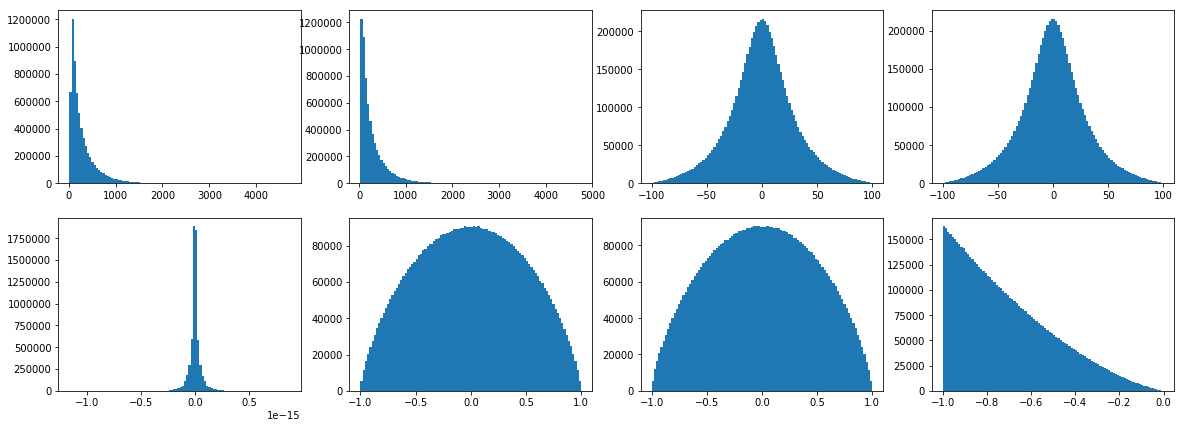

In [20]:
testRun()

#### Test after adding 2D target simulation feature

2019-02-08 08:43:38.273410
10000000 6475339 18.96151531697251


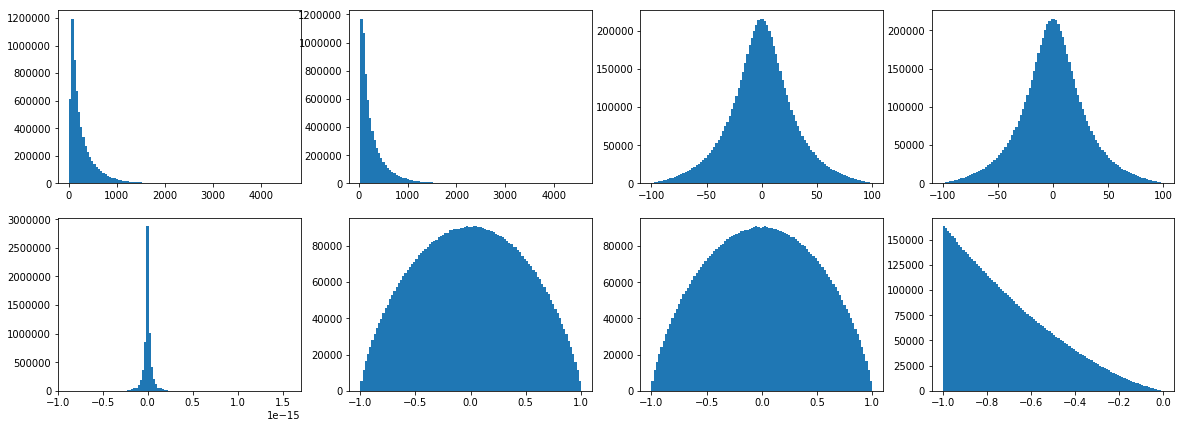

In [4]:
testRun() #Run time on Tomo's Computer

2019-02-08 08:45:03.655209
10000000 420874 15.35326342494227


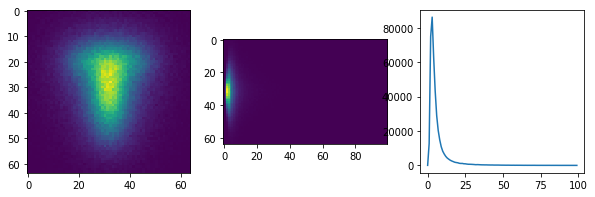

In [5]:
testRunTarget() #Run time on Tomo's Computer

#### Adding Illumination Source

2019-02-12 10:09:39.716050
10000000 6474735 18.951130707981065


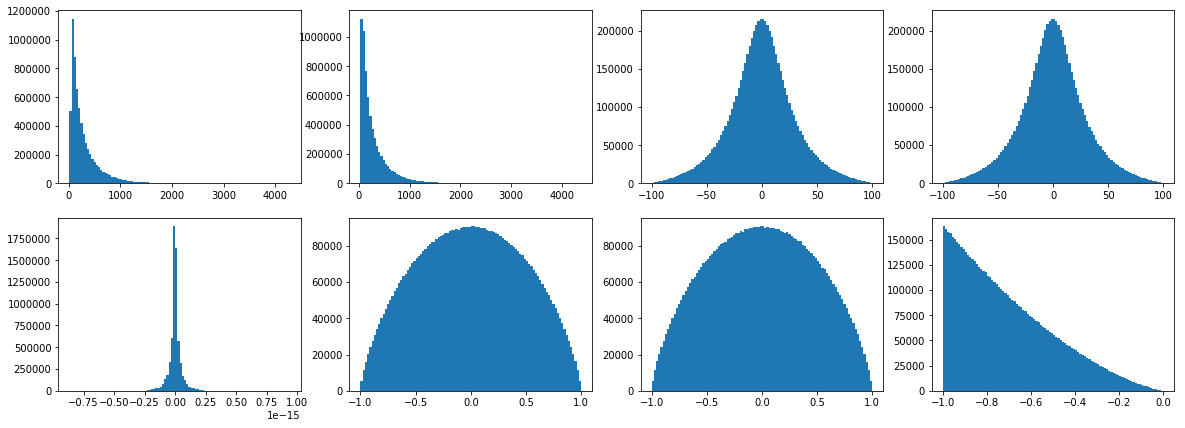

In [4]:
testRun() #Run time on Tomo's Computer

2019-02-12 10:10:34.391446
10000000 6474431 18.959465134888887


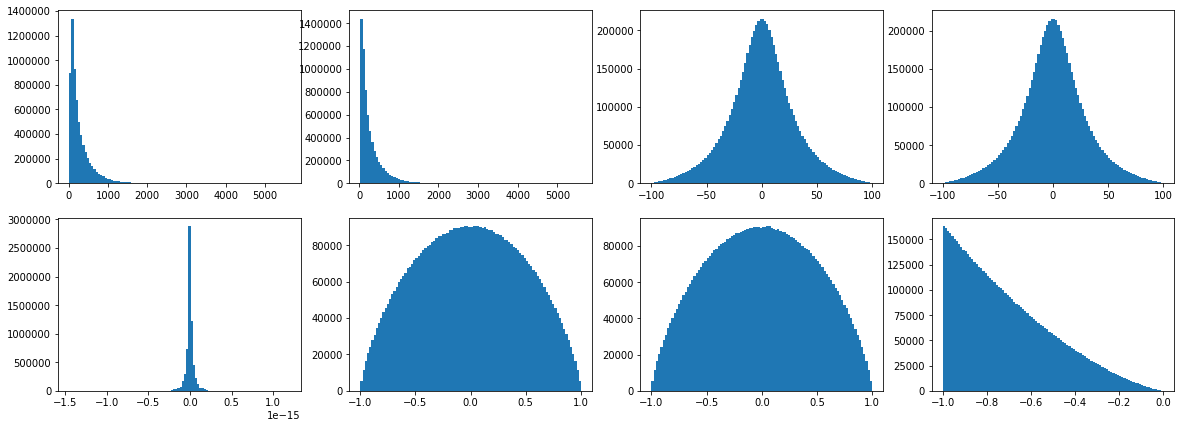

2019-02-12 10:11:11.708911
10000000 10000000 1.535413856850937


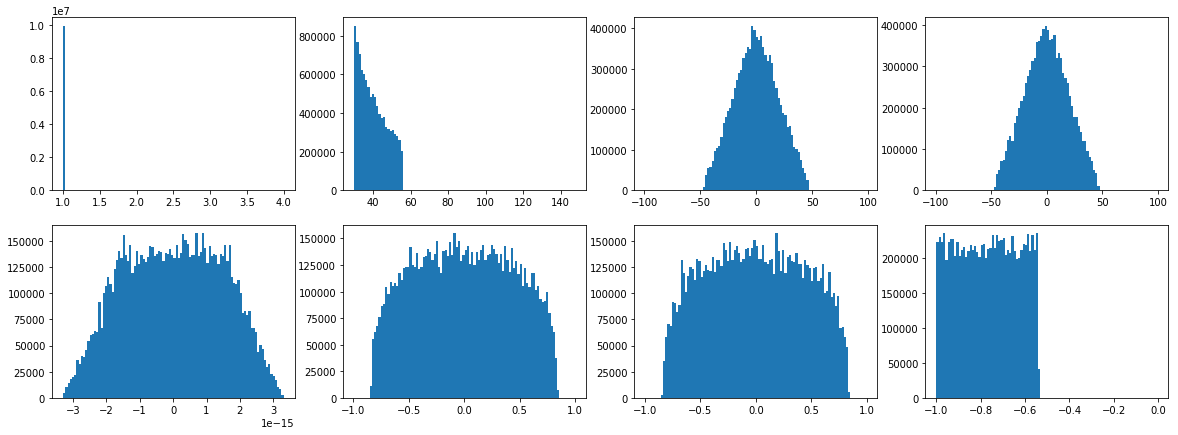

2019-02-12 10:11:42.129125
10000000 3578624 1.0985722388140857


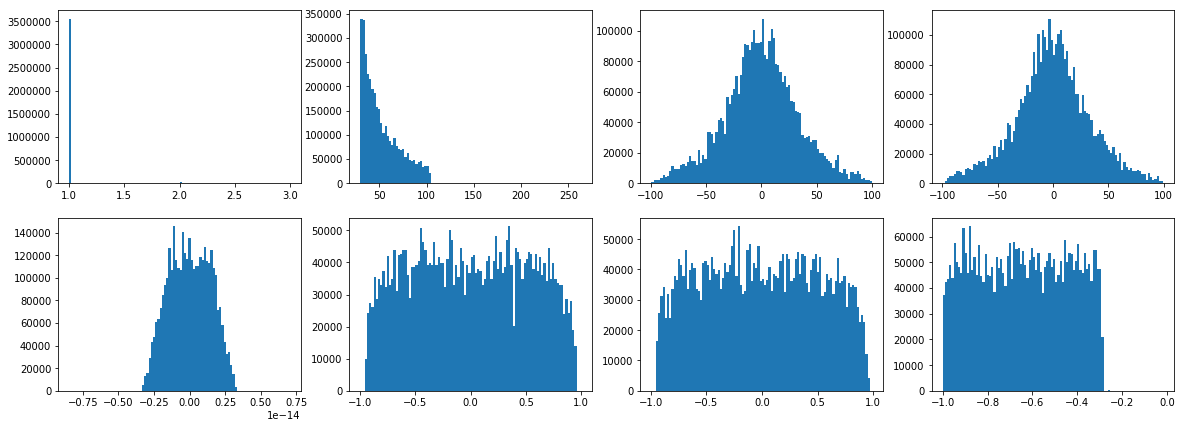

2019-02-12 10:11:54.451114
10000000 10000000 1.4815745980013162


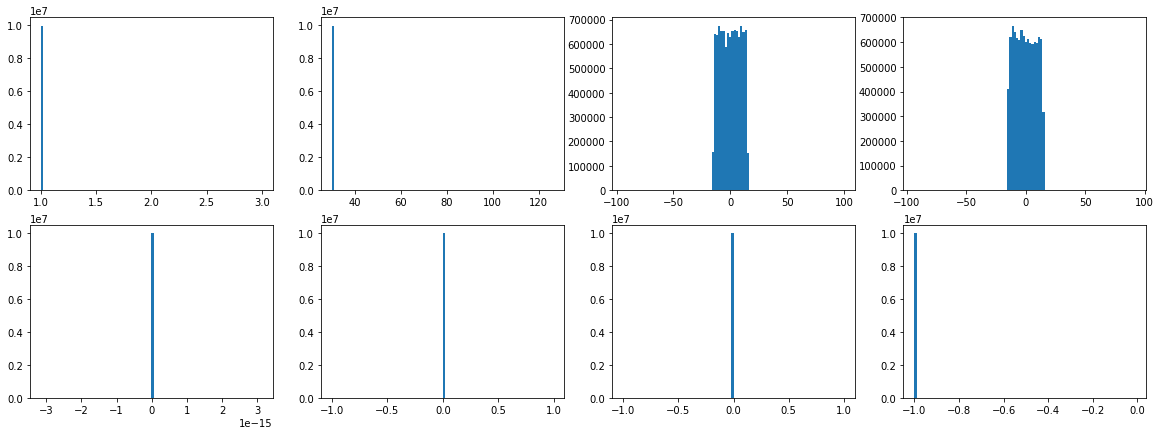

2019-02-12 10:12:23.238794
10000000 10000000 1.5171525578480214


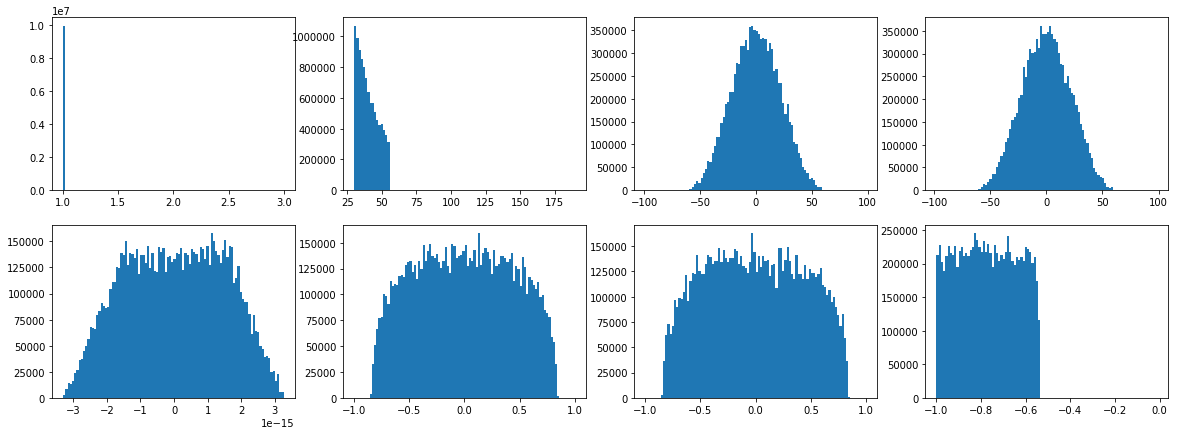

In [5]:
testRunIllumination(muS = 1.0, 
                       source = {'r': np.array([0.0, 0.0, 30.0]),
                                 'mu': np.array([0.0, 0.0, -1.0]),
                                 'theta': 0.0,
                                 'method': 'cone', 'time_profile': 'delta'}
                                ) #save as runTest() Comparing Time
testRunIllumination(muS = 0.0001,
                       source = {'r': np.array([0.0, 0.0, 30.0]),
                                 'mu': np.array([0.0, 0.0, -1.0]),
                                 'theta': 1.0, #theta is half angle
                                 'method': 'cone', 'time_profile': 'delta'}
                                ) #Test cone light source without scattering
testRunIllumination(muS = 0.0001,
                       source = {'r': np.array([0.0, 0.0, 30.0]),
                                 'mu': np.array([0.0, 0.0, -1.0]),
                                 'method': 'point', 'time_profile': 'delta'}
                                ) #Test point light source without scattering
testRunIllumination(muS = 0.0001,
                       source = {'r': np.array([0.0, 0.0, 30.0]),
                                 'mu': np.array([0.0, 0.0, -1.0]),
                                 'size': 30,
                                 'method': 'area', 'time_profile': 'delta'}
                                ) #Test area source without scattering
testRunIllumination(muS = 0.0001,
                       source = {'r': np.array([0.0, 0.0, 30.0]),
                                 'mu': np.array([0.0, 0.0, -1.0]),
                                 'size': 30,
                                 'theta': 1.0,
                                 'method': 'area_cone', 'time_profile': 'delta'}
                                ) #Test area cone source without scattering

# Adding scattering layer

2019-02-12 13:51:28.783066
10000000 6474727 17.082572473000255


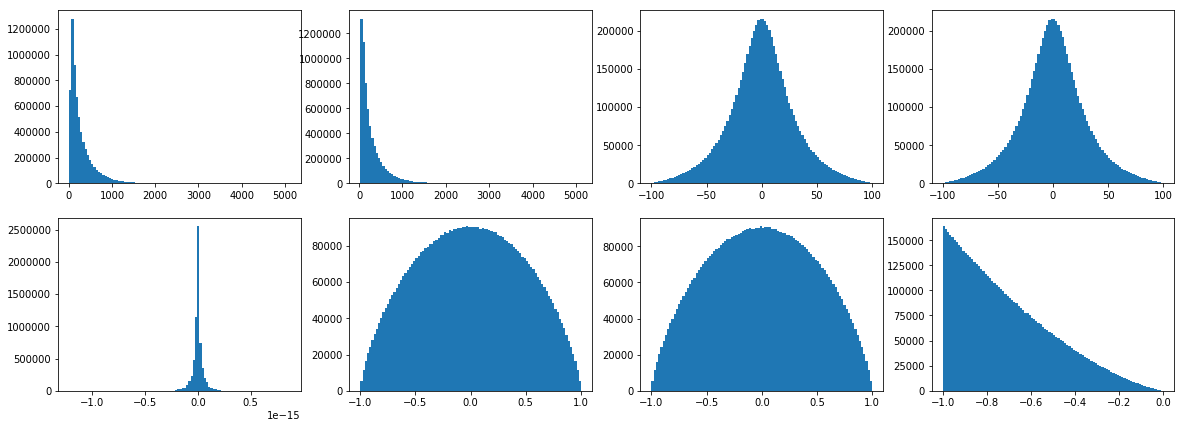

In [19]:
testRun()

2019-02-12 15:08:19.421708
1000000 918901 15.2951388700003


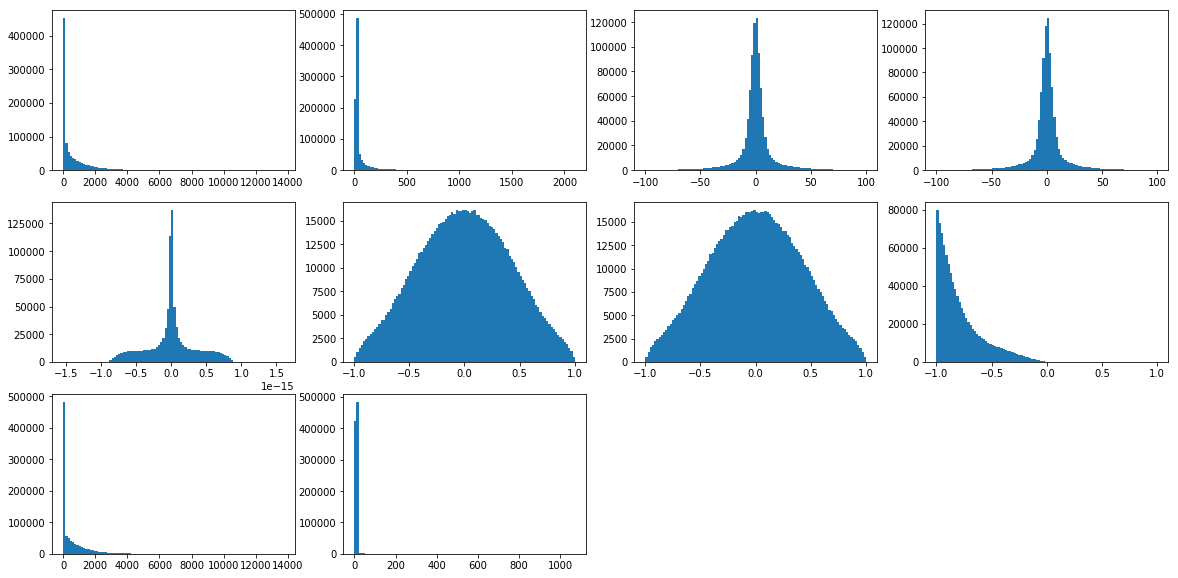

In [9]:
testRunScatteringTarget()

## Fixing a bug in scattering layer

2019-02-13 13:07:32.348474
10000000 6472711 19.22544233800727


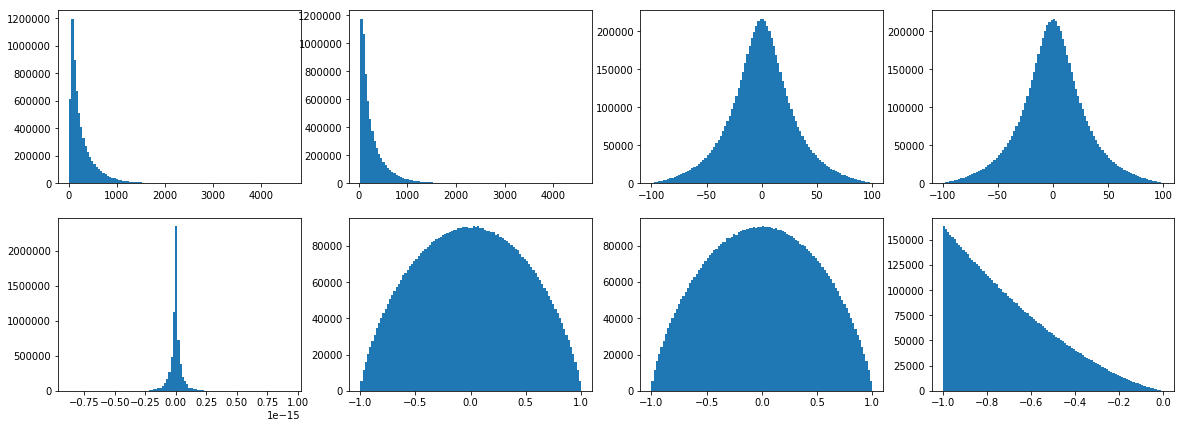

In [6]:
testRun()

2019-02-13 13:08:54.387380
1000000 913333 2.1998233369959053


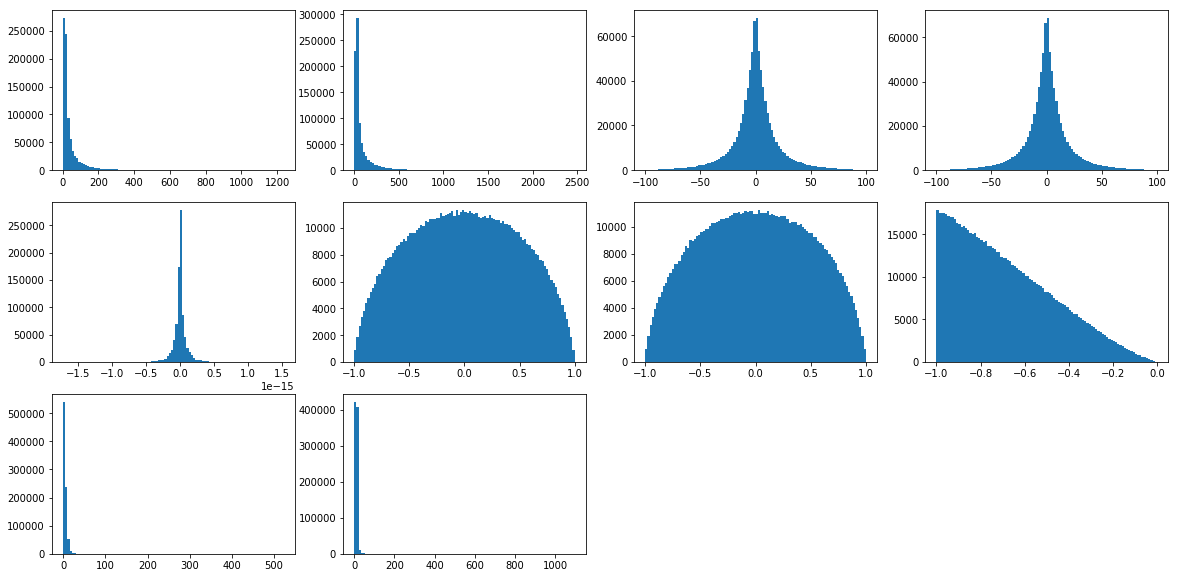

In [9]:
testRunScatteringTarget()

### Ading a lens

2019-02-14 18:26:45.857274
Detector type: 0, Aperture size: 100.0, f: 0.0, thickness: 0.0, R: 0.0, n: 0.0, z sensor: 0.0
10000000 6474860 17.745796367991716


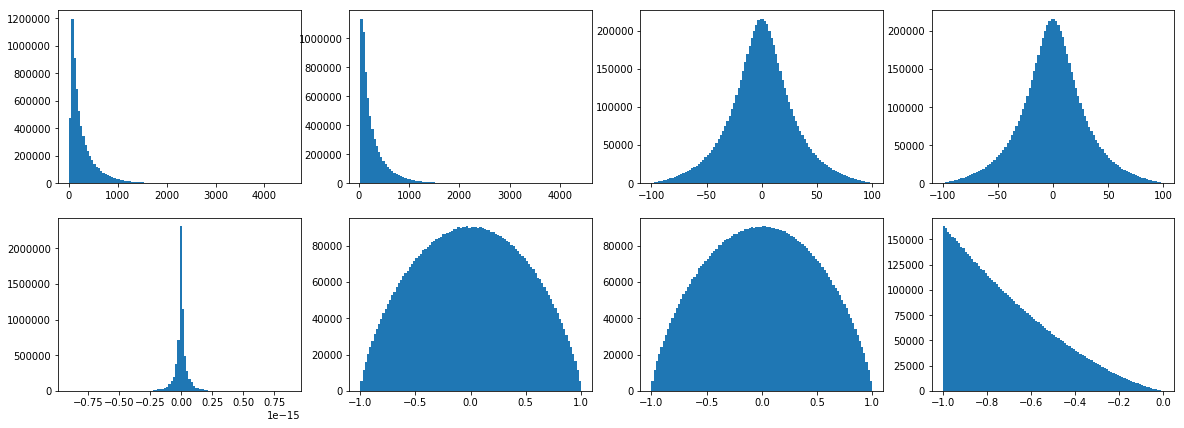

In [6]:
testRun()

2019-02-14 18:27:09.726203
Detector type: 1, Aperture size: 20.0, f: 6.7, thickness: 15.3, R: 21.0, n: 3.1, z sensor: 10.0
50000000 3263963 3.1486619260103907


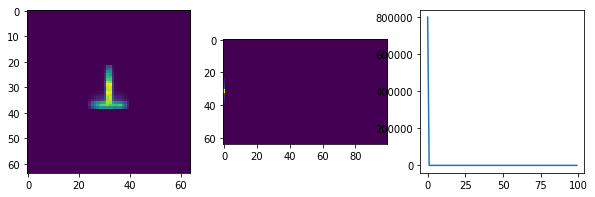

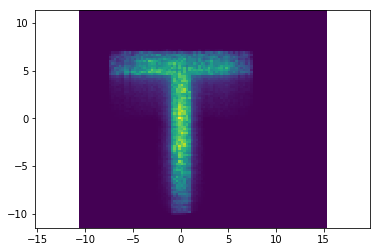

In [7]:
testRunTargetWithLens()

### Basic Multi GPU

2019-02-15 10:41:37.228266
Detector type: 0, Aperture size: 100.0, f: 0.0, thickness: 0.0, R: 0.0, n: 0.0, z sensor: 0.0
10000000 6474960 17.739571701997193


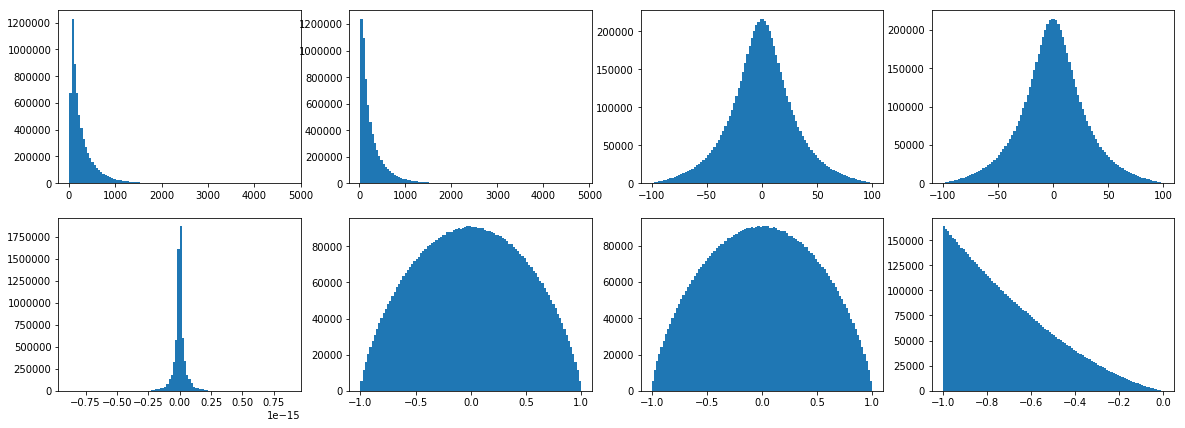

In [5]:
testRun()

In [4]:
t1 = time.perf_counter()
ret = MC.lunchPacketwithBatch(batchSize = 1e7,
                           nPhotonsRequested = 1e7,
                            nPhotonsToRun = 1e7,
                            muS = 1.0, g = 0.85,
                            source = {'r': np.array([0.0, 0.0, 30.0]),
                                      'mu': np.array([0.0, 0.0, -1.0]),
                                      'method': 'pencil', 'time_profile': 'delta'},
                            detector = {'radius': 100.0},
                            control_param = {'max_N': 1e5,
                                             'max_distance_from_det': 110},
                            normalize_d = None,
                            ret_cols = [0,1,2,3,4,5,6,7],
                            device_id = 6
                            )                                
print(ret[1], ret[2], time.perf_counter()-t1)

Detector type: 0, Aperture size: 100.0, f: 0.0, thickness: 0.0, R: 0.0, n: 0.0, z sensor: 0.0
10000000 6473327 17.52945324400207


### Structured Light

2019-02-19 09:25:49.043498
Detector type: 0, Aperture size: 100.0, f: 0.0, thickness: 0.0, R: 0.0, n: 0.0, z sensor: 0.0
10000000 6474029 22.118965908885002


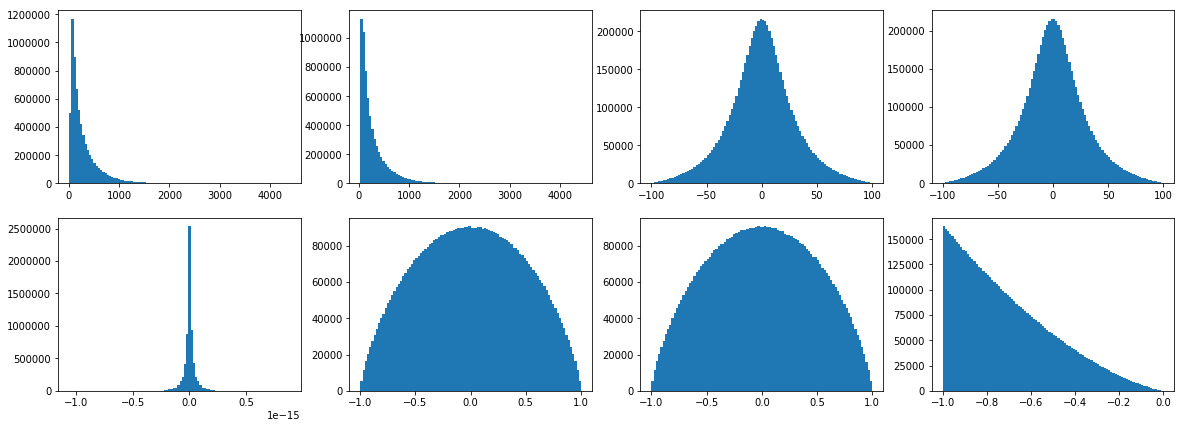

In [5]:
testRun()

2019-02-19 09:31:01.092260
Detector type: 0, Aperture size: 100.0, f: 0.0, thickness: 0.0, R: 0.0, n: 0.0, z sensor: 0.0
10000000 10000000 1.7730236798524857


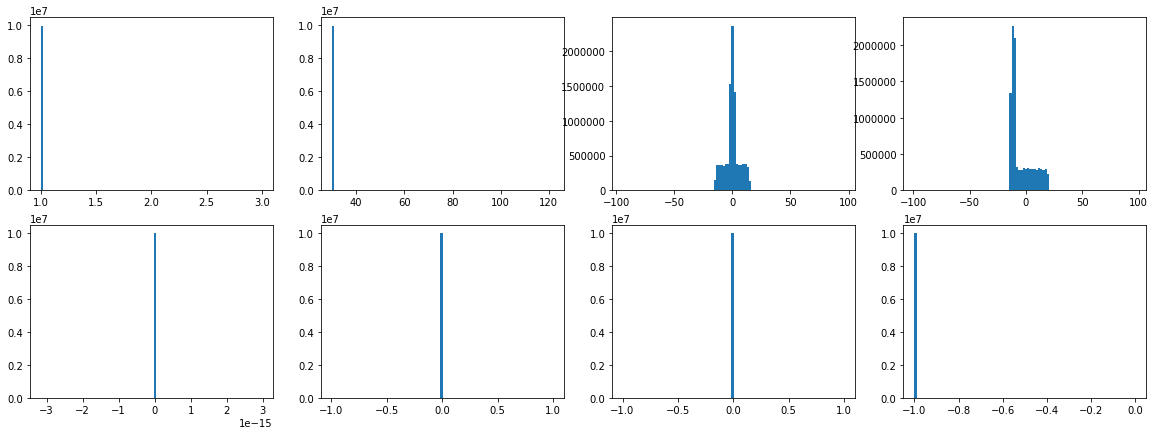

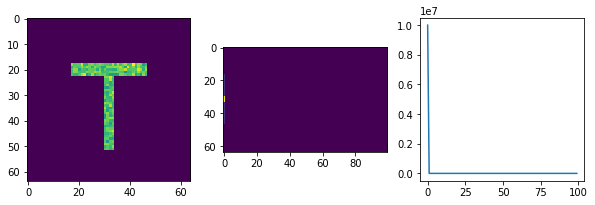

In [6]:
pattern = np.zeros(shape=(60,60))
pattern[21:50,28:32]=1
pattern[16:21,15:45]=1
testRunIllumination(muS = 0.0001, 
                    source = {'r': np.array([0.0, 0.0, 30.0]),
                              'mu': np.array([0.0, 0.0, -1.0]),
                              'theta': 0.0, 'size': 1,
                              'pattern': pattern,
                              'method': 'structured_pattern', 'time_profile': 'delta'}
                                ) #save as runTest() Comparing Time
data, num_simulated, num_detected = loadTest()
plotTargetTest(data)

2019-02-19 09:31:42.254516
Detector type: 0, Aperture size: 100.0, f: 0.0, thickness: 0.0, R: 0.0, n: 0.0, z sensor: 0.0
10000000 10000000 2.0831565894186497


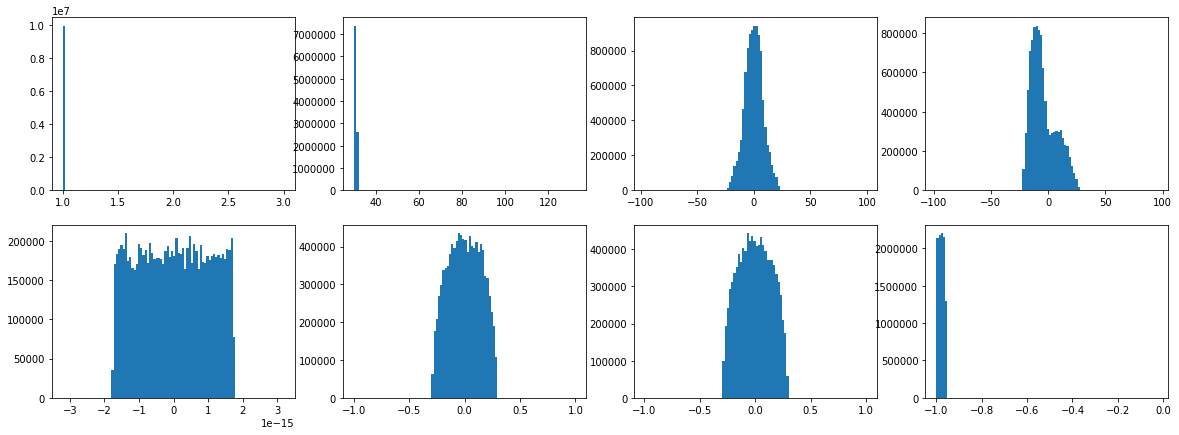

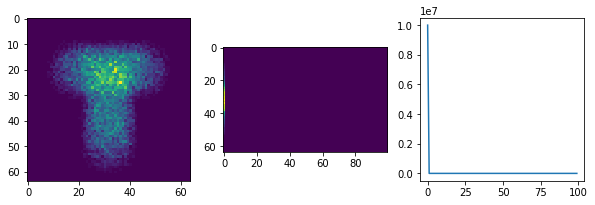

In [7]:
pattern = np.zeros(shape=(60,60))
pattern[21:50,28:32]=1
pattern[16:21,15:45]=1
testRunIllumination(muS = 0.0001, 
                    source = {'r': np.array([0.0, 0.0, 30.0]),
                              'mu': np.array([0.0, 0.0, -1.0]),
                              'theta': 0.3, 'size': 1,
                              'pattern': pattern,
                              'method': 'structured_pattern_cone', 'time_profile': 'delta'}
                                ) #save as runTest() Comparing Time
data, num_simulated, num_detected = loadTest()
plotTargetTest(data)

### Fixing Minor bug of target simulation

2019-02-17 16:12:58.078153
Detector type: 0, Aperture size: 100.0, f: 0.0, thickness: 0.0, R: 0.0, n: 0.0, z sensor: 0.0
10000000 6474580 19.836656905012205


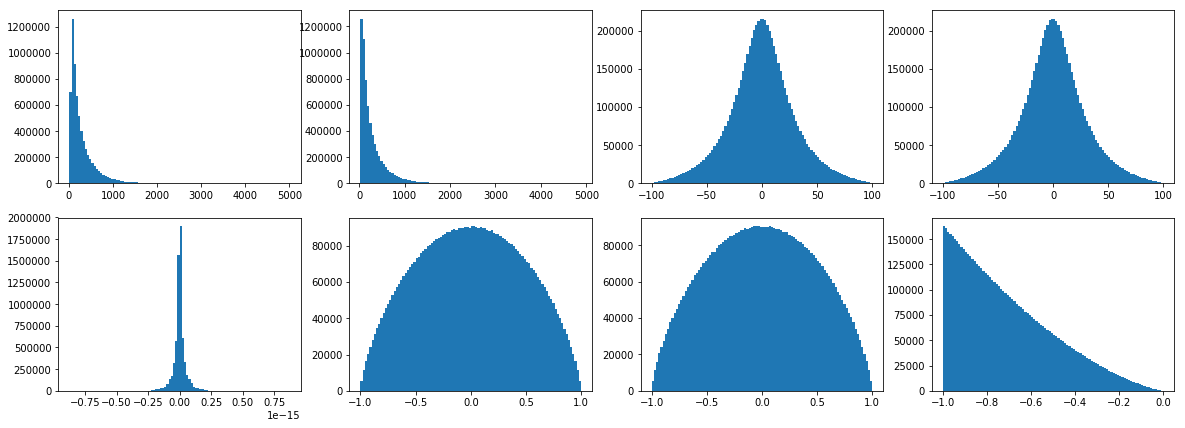

In [4]:
testRun()

In [ ]:
testRunTarget() 

2019-02-17 16:32:17.385292
Detector type: 1, Aperture size: 20.0, f: 6.7, thickness: 15.3, R: 21.0, n: 3.1, z sensor: 10.0
50000000 798047 4.566944146994501


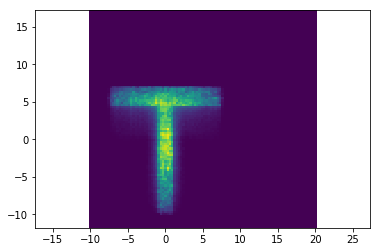

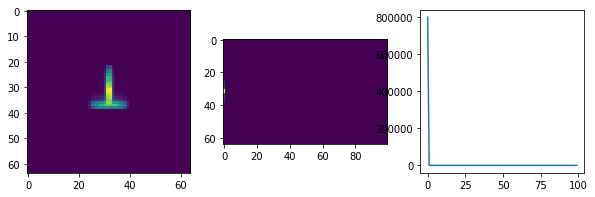

In [11]:
testRunTargetWithLens()

## Testing Parallel

2019-02-22 18:29:47.883268
Detector type: 0, Aperture size: 100.0, f: 0.0, thickness: 0.0, R: 0.0, n: 0.0, z sensor: 0.0
10000000 6474185 17.681764308013953


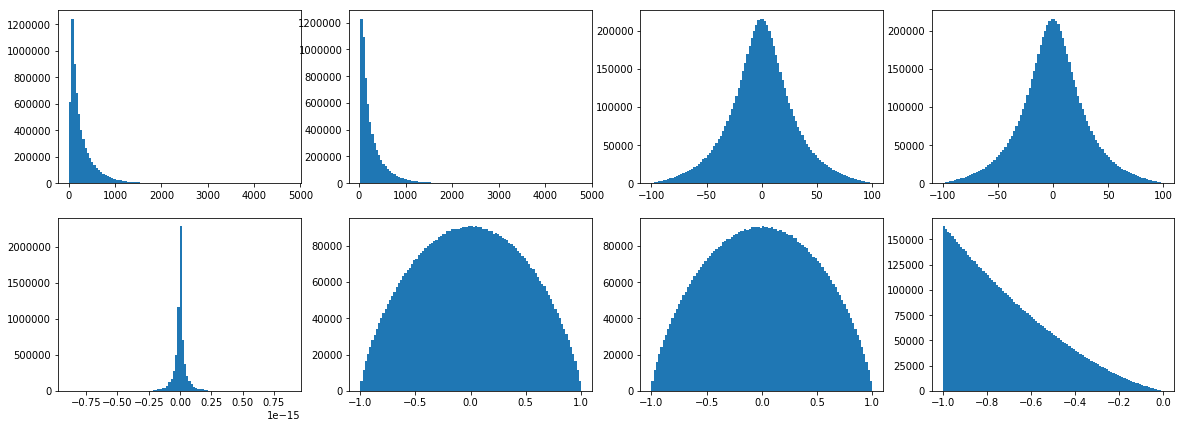

In [4]:
testRun()

Running in parallel
2019-02-22 18:31:18.474161
Detector type: 0, Aperture size: 100.0, f: 0.0, thickness: 0.0, R: 0.0, n: 0.0, z sensor: 0.0
10000000 6526089 2.9971748819807544


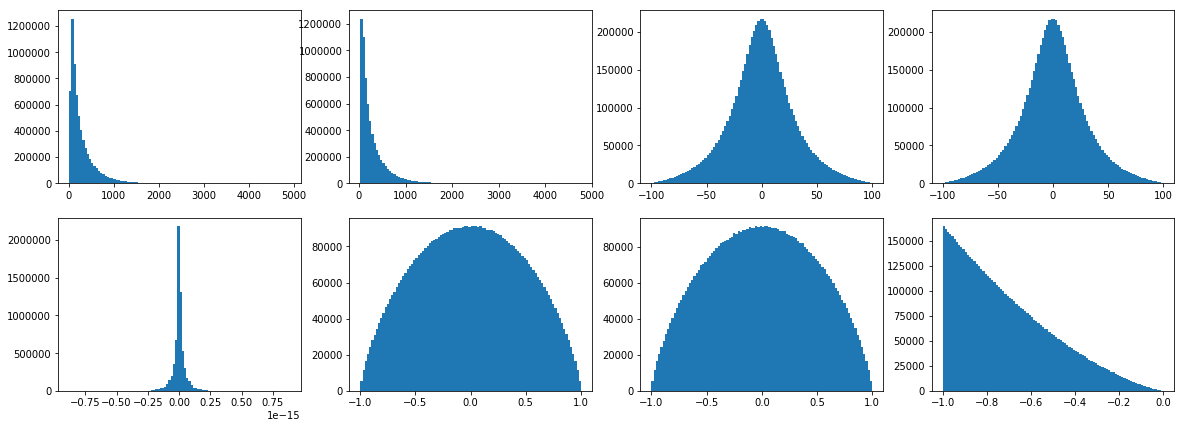

In [4]:
testRunParallel()

## New way of handling photon returns

2019-02-25 17:22:52.404084
Detector type: 0, Aperture size: 100.0, f: 0.0, thickness: 0.0, R: 0.0, n: 0.0, z sensor: 0.0
10010624 6473364 17.620295238999915


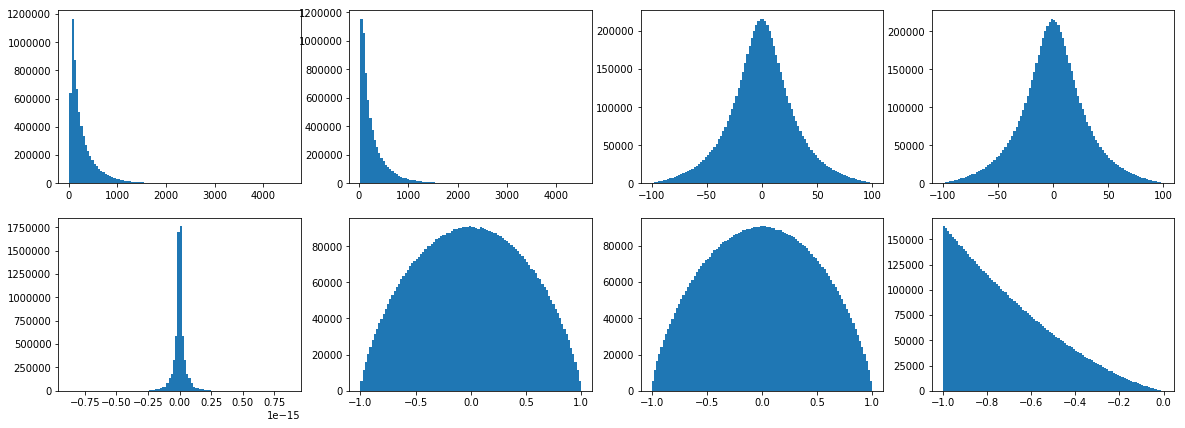

In [7]:
testRun()

Running in parallel
2019-02-25 17:22:37.746181
Detector type: 0, Aperture size: 100.0, f: 0.0, thickness: 0.0, R: 0.0, n: 0.0, z sensor: 0.0
10092544 6528703 4.225269461999915


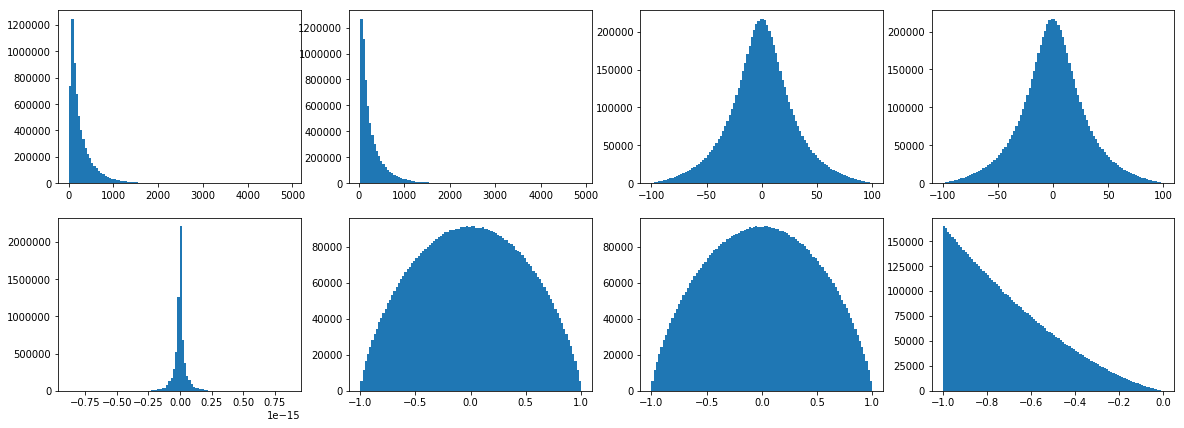

In [6]:
testRunParallel()

## Lens Bug

2019-03-12 11:56:26.570038
Detector type: 0, Aperture size: 100.0, f: 0.0, thickness: 0.0, R: 0.0, n: 0.0, z sensor: 0.0
10010624 6473839 19.370289619022515


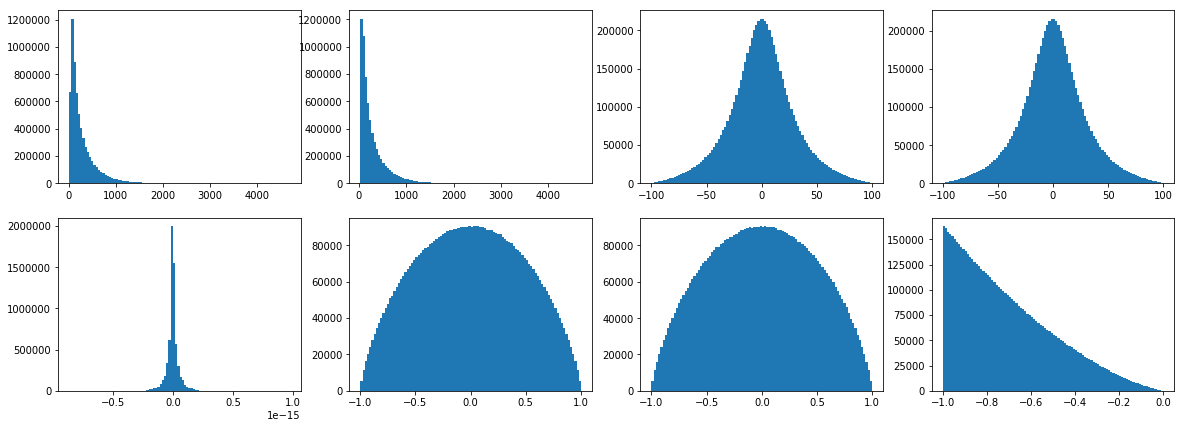

In [23]:
testRun()

2019-03-12 11:58:28.955260
Detector type: 1, Aperture size: 20.0, f: 6.7, thickness: 15.3, R: 21.0, n: 3.1, z sensor: 10.0
99309517 718252 1.768528199987486


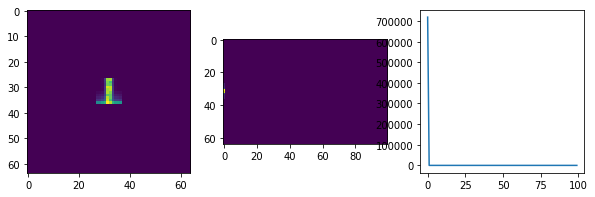

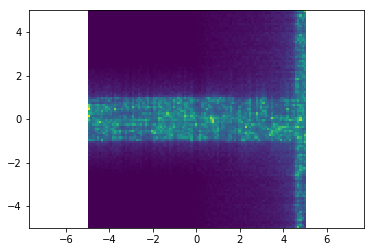

In [28]:
testRunTargetWithLens()